<a href="https://colab.research.google.com/github/prachi735/EVA5/blob/main/session6/EVA5_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

In [2]:
!pip install torchsummary
from torchsummary import summary


# Transformations

In [3]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                      # transforms.RandomAffine((-5.0,5.0),fillcolor=1),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [4]:
train = datasets.MNIST('./data', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data', train=True, download=True,transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloaders: Test/Train dataset

In [5]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics & Sample Data



[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - mean: tensor(33.3184)
 - std: tensor(78.5675)
 - var: tensor(6172.8506)
torch.Size([128, 1, 28, 28])
torch.Size([128])


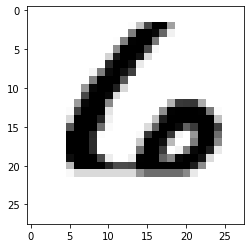

In [6]:
# converting array into numpy from tensor
train_data = train.train_data
#train_data = train.transform(train.train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.Tensor.float(train_data).mean())
print(' - std:', torch.Tensor.float(train_data).std())
print(' - var:', torch.Tensor.float(train_data).var())

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[52].numpy().squeeze(), cmap='gray_r')


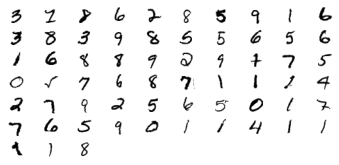

In [7]:
figure = plt.figure()
num_of_images = 63
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Data properties

In [8]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


# Basic Model

In [9]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [10]:
class Net(nn.Module):
    def __init__(self, is_GBN = False,gbn_splits = 2):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 26 output_size = 24 receptive_field = 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, gbn_splits) if is_gbn else nn.BatchNorm2d(16)
        ) # input_size = 12 output_size = 10 receptive_field = 5

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 12 output_size = 10 receptive_field = 5


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24 output_size = 12 receptive_field = 

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, gbn_splits) if is_gbn else nn.BatchNorm2d(16)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, gbn_splits) if is_gbn else nn.BatchNorm2d(16)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        # OUTPUT BLOCK
        self.convblock10 = nn.Sequential(
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)   
        
    

#Training & Testing

In [11]:
tqdm(train_loader)

NameError: ignored

In [12]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_losses,train_acc, l1_loss_flag, lamda_l1 = 0.0001):
  
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # if l1_loss_flag:
    #   l1 = 0
    #   for p in model.parameters():
    #     l1 = l1+p.abs().sum()
    #   loss += lamda_l1 * l1
      
    train_losses.append(loss)#.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader,test_losses, test_acc):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


# Train & Test model

In [13]:
def run_model(model,device,optimiser, EPOCHS = 1,is_L1_loss = False, is_GBN = False,gbn_splits=2):
  
  train_losses=[]
  train_acc=[]
  test_losses=[]
  test_acc=[]
    
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1)
      train(model, device, train_loader, optimizer,epoch, train_losses,train_acc, is_L1_loss, lamda_l1=0.0001)
      test(model, device, test_loader,test_losses, test_acc)
        
  return {'train_loss':train_losses,  'train_acc':train_acc,  'test_loss':test_losses,  'test_acc':test_acc}

In [14]:
  is_l1_loss = False
  is_gbn = False
  gbn_splits = 2

  data = {}
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  
  model = Net(is_gbn,gbn_splits).to(device)
  #print(summary(model, input_size=(1,28,28)))
  
  optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0.9)
  EPOCHS = 
  data['basic'] = run_model(model,device,optimizer, EPOCHS, is_l1_loss, is_gbn, gbn_splits)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.04969705641269684 Batch_id=468 Accuracy=92.01: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]



Test set: Average loss: 0.0728, Accuracy: 58741/60000 (97.90%)



In [19]:
check_cond = ["L1+BN", "L2+BN", "L1+L2+BN","GBN","L1+L2+GBN"]
l1_loss_flag = False
GBN_loss_flag = False
EPOCHS = 5
data = {}
for chck in check_cond:
  print("\nModel Running for:",chck)
  is_l1_loss = "L1" in chck   
  is_gbn = "GBN" in chck
  gbn_splits = 2

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  
  model = Net(is_gbn,gbn_splits).to(device)
  print(summary(model, input_size=(1,28,28)))
  
  if chck in [ "L2+BN", "L1+L2+BN","L1+L2+GBN"]:
    optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0, weight_decay=0,nesterov=False)
  else:
    optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0.9)
  
  print("L1_Flag",l1_loss_flag)
  print("GBN_Flag",GBN_loss_flag)
  data[chck] = run_model(model,device,optimizer,EPOCHS, is_l1_loss, is_gbn, gbn_splits)
  



  0%|          | 0/469 [00:00<?, ?it/s]


Model Running for: L1+BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 10, 22, 22]             160
             ReLU-11           [-1, 10, 22, 22]               0
      BatchNorm2d-12           [-1, 10, 22, 22]              20
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Co


Loss=2.9603700637817383 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.9603700637817383 Batch_id=0 Accuracy=11.72:   0%|          | 1/469 [00:00<03:05,  2.52it/s]
Loss=2.5748279094696045 Batch_id=1 Accuracy=11.72:   0%|          | 1/469 [00:00<03:05,  2.52it/s]
Loss=2.679837465286255 Batch_id=2 Accuracy=13.02:   0%|          | 1/469 [00:00<03:05,  2.52it/s] 
Loss=2.3748762607574463 Batch_id=3 Accuracy=14.06:   0%|          | 1/469 [00:00<03:05,  2.52it/s]
Loss=2.3748762607574463 Batch_id=3 Accuracy=14.06:   1%|          | 4/469 [00:00<02:15,  3.42it/s]
Loss=2.3582701683044434 Batch_id=4 Accuracy=15.47:   1%|          | 4/469 [00:00<02:15,  3.42it/s]
Loss=2.1442573070526123 Batch_id=5 Accuracy=16.67:   1%|          | 4/469 [00:00<02:15,  3.42it/s]
Loss=2.114988088607788 Batch_id=6 Accuracy=18.42:   1%|          | 4/469 [00:00<02:15,  3.42it/s] 
Loss=2.114988088607788 Batch_id=6 Accuracy=18.42:   1%|▏         | 7/469 [00:00<01:39,  4.65it/s]
Loss=2.05434250831


Test set: Average loss: 0.0836, Accuracy: 58528/60000 (97.55%)

EPOCH: 2



Loss=0.08286038786172867 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08286038786172867 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:39,  2.94it/s]
Loss=0.12170219421386719 Batch_id=1 Accuracy=95.70:   0%|          | 1/469 [00:00<02:39,  2.94it/s]
Loss=0.17197063565254211 Batch_id=2 Accuracy=95.31:   0%|          | 1/469 [00:00<02:39,  2.94it/s]
Loss=0.13480661809444427 Batch_id=3 Accuracy=95.51:   0%|          | 1/469 [00:00<02:39,  2.94it/s]
Loss=0.13480661809444427 Batch_id=3 Accuracy=95.51:   1%|          | 4/469 [00:00<01:56,  4.00it/s]
Loss=0.07581385970115662 Batch_id=4 Accuracy=96.09:   1%|          | 4/469 [00:00<01:56,  4.00it/s]
Loss=0.06019210070371628 Batch_id=5 Accuracy=96.48:   1%|          | 4/469 [00:00<01:56,  4.00it/s]
Loss=0.09704415500164032 Batch_id=6 Accuracy=96.43:   1%|          | 4/469 [00:00<01:56,  4.00it/s]
Loss=0.09704415500164032 Batch_id=6 Accuracy=96.43:   1%|▏         | 7/469 [00:00<01:26,  5.37it/s]
Loss=0.


Test set: Average loss: 0.0544, Accuracy: 58978/60000 (98.30%)

EPOCH: 3



Loss=0.07706344872713089 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.07706344872713089 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:03,  3.80it/s]
Loss=0.023877089843153954 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:03,  3.80it/s]
Loss=0.04022033512592316 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:03,  3.80it/s] 
Loss=0.04022033512592316 Batch_id=2 Accuracy=98.44:   1%|          | 3/469 [00:00<01:34,  4.94it/s]
Loss=0.04210323840379715 Batch_id=3 Accuracy=98.63:   1%|          | 3/469 [00:00<01:34,  4.94it/s]
Loss=0.07586245983839035 Batch_id=4 Accuracy=98.59:   1%|          | 3/469 [00:00<01:34,  4.94it/s]
Loss=0.08903671056032181 Batch_id=5 Accuracy=98.18:   1%|          | 3/469 [00:00<01:34,  4.94it/s]
Loss=0.08903671056032181 Batch_id=5 Accuracy=98.18:   1%|▏         | 6/469 [00:00<01:11,  6.45it/s]
Loss=0.118846595287323 Batch_id=6 Accuracy=97.88:   1%|▏         | 6/469 [00:00<01:11,  6.45it/s]  
Loss=


Test set: Average loss: 0.0424, Accuracy: 59252/60000 (98.75%)

EPOCH: 4



Loss=0.04496785253286362 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.04496785253286362 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:49,  2.76it/s]
Loss=0.11513207852840424 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:49,  2.76it/s]
Loss=0.016197489574551582 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:49,  2.76it/s]
Loss=0.04291155934333801 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:49,  2.76it/s] 
Loss=0.04291155934333801 Batch_id=3 Accuracy=98.63:   1%|          | 4/469 [00:00<02:02,  3.79it/s]
Loss=0.045194193720817566 Batch_id=4 Accuracy=98.59:   1%|          | 4/469 [00:00<02:02,  3.79it/s]
Loss=0.01778266206383705 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<02:02,  3.79it/s] 
Loss=0.06259666383266449 Batch_id=6 Accuracy=98.44:   1%|          | 4/469 [00:00<02:02,  3.79it/s]
Loss=0.06259666383266449 Batch_id=6 Accuracy=98.44:   1%|▏         | 7/469 [00:00<01:31,  5.06it/s]
Los


Test set: Average loss: 0.0448, Accuracy: 59200/60000 (98.67%)

EPOCH: 5



Loss=0.026853403076529503 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.026853403076529503 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=0.05520954355597496 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:36,  2.99it/s] 
Loss=0.07220374792814255 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:36,  2.99it/s]
Loss=0.07220374792814255 Batch_id=2 Accuracy=98.18:   1%|          | 3/469 [00:00<01:56,  4.00it/s]
Loss=0.030843446031212807 Batch_id=3 Accuracy=98.44:   1%|          | 3/469 [00:00<01:56,  4.00it/s]
Loss=0.02693781815469265 Batch_id=4 Accuracy=98.44:   1%|          | 3/469 [00:00<01:56,  4.00it/s] 
Loss=0.02019530162215233 Batch_id=5 Accuracy=98.57:   1%|          | 3/469 [00:00<01:56,  4.00it/s]
Loss=0.02019530162215233 Batch_id=5 Accuracy=98.57:   1%|▏         | 6/469 [00:00<01:27,  5.29it/s]
Loss=0.055469583719968796 Batch_id=6 Accuracy=98.44:   1%|▏         | 6/469 [00:00<01:27,  5.29it/s]
L


Test set: Average loss: 0.0305, Accuracy: 59434/60000 (99.06%)


Model Running for: L2+BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 10, 22, 22]             160
             ReLU-11           [-1, 10, 22, 22]               0
      BatchNorm2d-12           [-1, 10, 22, 22]              20
        MaxP


Loss=2.871800422668457 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.871800422668457 Batch_id=0 Accuracy=8.59:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=2.748288869857788 Batch_id=1 Accuracy=8.98:   0%|          | 1/469 [00:00<02:20,  3.33it/s]
Loss=2.6253662109375 Batch_id=2 Accuracy=9.11:   1%|          | 3/469 [00:00<01:44,  4.44it/s]
Loss=2.4901180267333984 Batch_id=3 Accuracy=11.13:   1%|          | 3/469 [00:00<01:44,  4.44it/s]
Loss=2.4916300773620605 Batch_id=4 Accuracy=10.62:   1%|          | 3/469 [00:00<01:44,  4.44it/s]
Loss=2.31494402885437 Batch_id=5 Accuracy=11.59:   1%|          | 3/469 [00:00<01:44,  4.44it/s]  
Loss=2.31494402885437 Batch_id=5 Accuracy=11.59:   1%|▏         | 6/469 [00:00<01:19,  5.82it/s]
Loss=2.412684917449951 Batch_id=6 Accuracy=12.05:   1%|▏         | 6/469 [00:00<01:19,  5.82it/s]
Loss=2.360499858856201 Batch_id=7 Accuracy=12.50:   1%|▏         | 6/469 [00:00<01:19,  5.82it/s]
Loss=2.1743667125701904 Batch_i


Test set: Average loss: 0.2632, Accuracy: 57023/60000 (95.04%)

EPOCH: 2



Loss=0.22839681804180145 Batch_id=0 Accuracy=94.53:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.22839681804180145 Batch_id=0 Accuracy=94.53:   0%|          | 1/469 [00:00<02:47,  2.79it/s]
Loss=0.2767412066459656 Batch_id=1 Accuracy=95.70:   0%|          | 1/469 [00:00<02:47,  2.79it/s] 
Loss=0.2987615764141083 Batch_id=2 Accuracy=95.05:   0%|          | 1/469 [00:00<02:47,  2.79it/s]
Loss=0.25619637966156006 Batch_id=3 Accuracy=94.92:   0%|          | 1/469 [00:00<02:47,  2.79it/s]
Loss=0.25619637966156006 Batch_id=3 Accuracy=94.92:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.2031213939189911 Batch_id=4 Accuracy=95.47:   1%|          | 4/469 [00:00<02:02,  3.81it/s] 
Loss=0.22837617993354797 Batch_id=5 Accuracy=95.70:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.275831937789917 Batch_id=6 Accuracy=95.65:   1%|          | 4/469 [00:00<02:02,  3.81it/s]  
Loss=0.275831937789917 Batch_id=6 Accuracy=95.65:   1%|▏         | 7/469 [00:00<01:30,  5.11it/s]
Loss=0.237


Test set: Average loss: 0.1414, Accuracy: 58125/60000 (96.88%)

EPOCH: 3



Loss=0.18699723482131958 Batch_id=0 Accuracy=92.97:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.18699723482131958 Batch_id=0 Accuracy=92.97:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.15445779263973236 Batch_id=1 Accuracy=94.92:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.178428515791893 Batch_id=2 Accuracy=95.83:   0%|          | 1/469 [00:00<02:48,  2.78it/s]  
Loss=0.1671144962310791 Batch_id=3 Accuracy=95.70:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.15137973427772522 Batch_id=4 Accuracy=95.94:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.15137973427772522 Batch_id=4 Accuracy=95.94:   1%|          | 5/469 [00:00<02:02,  3.77it/s]
Loss=0.14934468269348145 Batch_id=5 Accuracy=96.09:   1%|          | 5/469 [00:00<02:02,  3.77it/s]
Loss=0.19054998457431793 Batch_id=6 Accuracy=95.98:   1%|          | 5/469 [00:00<02:02,  3.77it/s]
Loss=0.10581096261739731 Batch_id=7 Accuracy=96.19:   1%|          | 5/469 [00:00<02:02,  3.77it/s]
Loss=0.1


Test set: Average loss: 0.0990, Accuracy: 58637/60000 (97.73%)

EPOCH: 4



Loss=0.08670143783092499 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08670143783092499 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:31,  3.09it/s]
Loss=0.19036465883255005 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:31,  3.09it/s] 
Loss=0.06445620954036713 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:31,  3.09it/s]
Loss=0.08747225254774094 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:31,  3.09it/s]
Loss=0.08747225254774094 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<01:50,  4.21it/s]
Loss=0.12808606028556824 Batch_id=4 Accuracy=98.12:   1%|          | 4/469 [00:00<01:50,  4.21it/s]
Loss=0.11832492798566818 Batch_id=5 Accuracy=97.92:   1%|          | 4/469 [00:00<01:50,  4.21it/s]
Loss=0.11537860333919525 Batch_id=6 Accuracy=97.99:   1%|          | 4/469 [00:00<01:50,  4.21it/s]
Loss=0.11537860333919525 Batch_id=6 Accuracy=97.99:   1%|▏         | 7/469 [00:00<01:22,  5.58it/s]
Loss


Test set: Average loss: 0.0794, Accuracy: 58826/60000 (98.04%)

EPOCH: 5



Loss=0.05608510971069336 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05608510971069336 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.049730319529771805 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.10700163245201111 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:25,  3.22it/s] 
Loss=0.11493944376707077 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.11852317303419113 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.11852317303419113 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:45,  4.41it/s]
Loss=0.05412490665912628 Batch_id=5 Accuracy=98.18:   1%|          | 5/469 [00:00<01:45,  4.41it/s]
Loss=0.05861514061689377 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:45,  4.41it/s]
Loss=0.05861514061689377 Batch_id=6 Accuracy=98.44:   1%|▏         | 7/469 [00:00<01:20,  5.72it/s]
Loss=


Test set: Average loss: 0.0678, Accuracy: 58956/60000 (98.26%)


Model Running for: L1+L2+BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 10, 22, 22]             160
             ReLU-11           [-1, 10, 22, 22]               0
      BatchNorm2d-12           [-1, 10, 22, 22]              20
        M


Loss=2.928537368774414 Batch_id=0 Accuracy=10.94:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.928537368774414 Batch_id=0 Accuracy=10.94:   0%|          | 1/469 [00:00<02:34,  3.03it/s]
Loss=2.8588836193084717 Batch_id=1 Accuracy=13.28:   0%|          | 1/469 [00:00<02:34,  3.03it/s]
Loss=2.705281972885132 Batch_id=2 Accuracy=12.50:   0%|          | 1/469 [00:00<02:34,  3.03it/s] 
Loss=2.735928535461426 Batch_id=3 Accuracy=13.87:   0%|          | 1/469 [00:00<02:34,  3.03it/s]
Loss=2.464810371398926 Batch_id=4 Accuracy=13.59:   0%|          | 1/469 [00:00<02:34,  3.03it/s]
Loss=2.464810371398926 Batch_id=4 Accuracy=13.59:   1%|          | 5/469 [00:00<01:52,  4.12it/s]
Loss=2.5642776489257812 Batch_id=5 Accuracy=14.58:   1%|          | 5/469 [00:00<01:52,  4.12it/s]
Loss=2.5099549293518066 Batch_id=6 Accuracy=14.73:   1%|          | 5/469 [00:00<01:52,  4.12it/s]
Loss=2.435389280319214 Batch_id=7 Accuracy=15.33:   1%|          | 5/469 [00:00<01:52,  4.12it/s] 
Loss=2.435389280319214


Test set: Average loss: 0.2689, Accuracy: 56653/60000 (94.42%)

EPOCH: 2



Loss=0.29077136516571045 Batch_id=0 Accuracy=94.53:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.29077136516571045 Batch_id=0 Accuracy=94.53:   0%|          | 1/469 [00:00<02:33,  3.06it/s]
Loss=0.32008489966392517 Batch_id=1 Accuracy=93.75:   0%|          | 1/469 [00:00<02:33,  3.06it/s]
Loss=0.2573663592338562 Batch_id=2 Accuracy=94.01:   0%|          | 1/469 [00:00<02:33,  3.06it/s] 
Loss=0.2770090401172638 Batch_id=3 Accuracy=94.14:   0%|          | 1/469 [00:00<02:33,  3.06it/s]
Loss=0.2770090401172638 Batch_id=3 Accuracy=94.14:   1%|          | 4/469 [00:00<01:51,  4.16it/s]
Loss=0.3240734934806824 Batch_id=4 Accuracy=93.91:   1%|          | 4/469 [00:00<01:51,  4.16it/s]
Loss=0.20378924906253815 Batch_id=5 Accuracy=94.66:   1%|          | 4/469 [00:00<01:51,  4.16it/s]
Loss=0.3067537844181061 Batch_id=6 Accuracy=94.31:   1%|          | 4/469 [00:00<01:51,  4.16it/s] 
Loss=0.3067537844181061 Batch_id=6 Accuracy=94.31:   1%|▏         | 7/469 [00:00<01:22,  5.59it/s]
Loss=0.3004


Test set: Average loss: 0.1408, Accuracy: 58112/60000 (96.85%)

EPOCH: 3



Loss=0.20306085050106049 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.20306085050106049 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=0.12015300244092941 Batch_id=1 Accuracy=96.09:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=0.168243408203125 Batch_id=2 Accuracy=96.35:   0%|          | 1/469 [00:00<02:26,  3.20it/s]  
Loss=0.11619039624929428 Batch_id=3 Accuracy=96.68:   0%|          | 1/469 [00:00<02:26,  3.20it/s]
Loss=0.11619039624929428 Batch_id=3 Accuracy=96.68:   1%|          | 4/469 [00:00<01:46,  4.35it/s]
Loss=0.13023695349693298 Batch_id=4 Accuracy=96.72:   1%|          | 4/469 [00:00<01:46,  4.35it/s]
Loss=0.15447759628295898 Batch_id=5 Accuracy=96.48:   1%|          | 4/469 [00:00<01:46,  4.35it/s]
Loss=0.13107800483703613 Batch_id=6 Accuracy=96.65:   1%|          | 4/469 [00:00<01:46,  4.35it/s]
Loss=0.13107800483703613 Batch_id=6 Accuracy=96.65:   1%|▏         | 7/469 [00:00<01:19,  5.79it/s]
Loss=0.


Test set: Average loss: 0.1033, Accuracy: 58452/60000 (97.42%)

EPOCH: 4



Loss=0.1500026434659958 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1500026434659958 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:01,  3.85it/s]
Loss=0.12574288249015808 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<02:01,  3.85it/s]
Loss=0.12574288249015808 Batch_id=1 Accuracy=96.48:   0%|          | 2/469 [00:00<01:40,  4.66it/s]
Loss=0.16022953391075134 Batch_id=2 Accuracy=96.61:   0%|          | 2/469 [00:00<01:40,  4.66it/s]
Loss=0.06412893533706665 Batch_id=3 Accuracy=97.27:   0%|          | 2/469 [00:00<01:40,  4.66it/s]
Loss=0.049997154623270035 Batch_id=4 Accuracy=97.81:   0%|          | 2/469 [00:00<01:40,  4.66it/s]
Loss=0.10248470306396484 Batch_id=5 Accuracy=97.66:   0%|          | 2/469 [00:00<01:40,  4.66it/s] 
Loss=0.10248470306396484 Batch_id=5 Accuracy=97.66:   1%|▏         | 6/469 [00:00<01:15,  6.14it/s]
Loss=0.06134180724620819 Batch_id=6 Accuracy=97.77:   1%|▏         | 6/469 [00:00<01:15,  6.14it/s]
Loss=0.


Test set: Average loss: 0.0789, Accuracy: 58825/60000 (98.04%)

EPOCH: 5



Loss=0.07838329672813416 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.07838329672813416 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:37,  2.97it/s]
Loss=0.08655194938182831 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:37,  2.97it/s]
Loss=0.04160217195749283 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:37,  2.97it/s]
Loss=0.16927079856395721 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:37,  2.97it/s]
Loss=0.07844541221857071 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:37,  2.97it/s]
Loss=0.07844541221857071 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:54,  4.05it/s]
Loss=0.0677964985370636 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:54,  4.05it/s] 
Loss=0.06411267071962357 Batch_id=6 Accuracy=98.21:   1%|          | 5/469 [00:00<01:54,  4.05it/s]
Loss=0.061589211225509644 Batch_id=7 Accuracy=98.34:   1%|          | 5/469 [00:00<01:54,  4.05it/s]
Loss=0


Test set: Average loss: 0.0743, Accuracy: 58810/60000 (98.02%)


Model Running for: GBN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
    GhostBatchNorm-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
    GhostBatchNorm-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 10, 22, 22]             160
             ReLU-11           [-1, 10, 22, 22]               0
   GhostBatchNorm-12           [-1, 10, 22, 22]              20
        MaxPoo


Loss=2.8953921794891357 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.8953921794891357 Batch_id=0 Accuracy=8.59:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=2.6541237831115723 Batch_id=1 Accuracy=9.77:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=2.6627697944641113 Batch_id=2 Accuracy=11.46:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=2.6627697944641113 Batch_id=2 Accuracy=11.46:   1%|          | 3/469 [00:00<01:56,  4.01it/s]
Loss=2.4832961559295654 Batch_id=3 Accuracy=12.50:   1%|          | 3/469 [00:00<01:56,  4.01it/s]
Loss=2.436972141265869 Batch_id=4 Accuracy=13.28:   1%|          | 3/469 [00:00<01:56,  4.01it/s] 
Loss=2.241328239440918 Batch_id=5 Accuracy=15.10:   1%|          | 3/469 [00:00<01:56,  4.01it/s]
Loss=2.241328239440918 Batch_id=5 Accuracy=15.10:   1%|▏         | 6/469 [00:00<01:27,  5.30it/s]
Loss=2.2137632369995117 Batch_id=6 Accuracy=15.29:   1%|▏         | 6/469 [00:00<01:27,  5.30it/s]
Loss=2.059838533401489


Test set: Average loss: 0.0850, Accuracy: 58522/60000 (97.54%)

EPOCH: 2



Loss=0.07076119631528854 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.07076119631528854 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:34,  3.04it/s]
Loss=0.05000672861933708 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:34,  3.04it/s]
Loss=0.11993027478456497 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:34,  3.04it/s]
Loss=0.13268959522247314 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:34,  3.04it/s]
Loss=0.13268959522247314 Batch_id=3 Accuracy=97.85:   1%|          | 4/469 [00:00<01:53,  4.09it/s]
Loss=0.03975794091820717 Batch_id=4 Accuracy=97.97:   1%|          | 4/469 [00:00<01:53,  4.09it/s]
Loss=0.08951764553785324 Batch_id=5 Accuracy=97.92:   1%|          | 4/469 [00:00<01:53,  4.09it/s]
Loss=0.09092846512794495 Batch_id=6 Accuracy=97.88:   1%|          | 4/469 [00:00<01:53,  4.09it/s]
Loss=0.09092846512794495 Batch_id=6 Accuracy=97.88:   1%|▏         | 7/469 [00:00<01:24,  5.46it/s]
Loss=0.


Test set: Average loss: 0.0533, Accuracy: 59091/60000 (98.48%)

EPOCH: 3



Loss=0.053960200399160385 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.053960200399160385 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:54,  2.69it/s]
Loss=0.07273640483617783 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:54,  2.69it/s] 
Loss=0.04052954539656639 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:54,  2.69it/s]
Loss=0.05684863030910492 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:54,  2.69it/s]
Loss=0.05684863030910492 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<02:07,  3.65it/s]
Loss=0.05343266576528549 Batch_id=4 Accuracy=97.97:   1%|          | 4/469 [00:00<02:07,  3.65it/s]
Loss=0.10488743335008621 Batch_id=5 Accuracy=98.05:   1%|          | 4/469 [00:00<02:07,  3.65it/s]
Loss=0.0647650882601738 Batch_id=6 Accuracy=98.10:   1%|          | 4/469 [00:00<02:07,  3.65it/s] 
Loss=0.0647650882601738 Batch_id=6 Accuracy=98.10:   1%|▏         | 7/469 [00:00<01:33,  4.93it/s]
Loss=


Test set: Average loss: 0.0504, Accuracy: 59092/60000 (98.49%)

EPOCH: 4



Loss=0.023458734154701233 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.023458734154701233 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:02,  3.83it/s]
Loss=0.01773042604327202 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:02,  3.83it/s]  
Loss=0.01773042604327202 Batch_id=1 Accuracy=99.61:   0%|          | 2/469 [00:00<01:40,  4.64it/s]
Loss=0.016345828771591187 Batch_id=2 Accuracy=99.74:   0%|          | 2/469 [00:00<01:40,  4.64it/s]
Loss=0.07145968824625015 Batch_id=3 Accuracy=99.22:   0%|          | 2/469 [00:00<01:40,  4.64it/s] 
Loss=0.09988977015018463 Batch_id=4 Accuracy=98.59:   0%|          | 2/469 [00:00<01:40,  4.64it/s]
Loss=0.09988977015018463 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:14,  6.20it/s]
Loss=0.036810167133808136 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:14,  6.20it/s]
Loss=0.06880646198987961 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:14,  6.20it/s


Test set: Average loss: 0.0389, Accuracy: 59309/60000 (98.85%)

EPOCH: 5



Loss=0.07664701342582703 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.07664701342582703 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.0639897957444191 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:46,  2.81it/s] 
Loss=0.027410702779889107 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.02402058243751526 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:46,  2.81it/s] 
Loss=0.02402058243751526 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.02240145206451416 Batch_id=4 Accuracy=98.75:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.008205472491681576 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.028461959213018417 Batch_id=6 Accuracy=99.00:   1%|          | 4/469 [00:00<02:02,  3.81it/s]
Loss=0.028461959213018417 Batch_id=6 Accuracy=99.00:   1%|▏         | 7/469 [00:00<01:30,  5.08it/s]
Lo


Test set: Average loss: 0.0344, Accuracy: 59395/60000 (98.99%)


Model Running for: L1+L2+GBN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
    GhostBatchNorm-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
    GhostBatchNorm-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 10, 22, 22]             160
             ReLU-11           [-1, 10, 22, 22]               0
   GhostBatchNorm-12           [-1, 10, 22, 22]              20
        


Loss=2.6410791873931885 Batch_id=0 Accuracy=14.06:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.6410791873931885 Batch_id=0 Accuracy=14.06:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=2.673200845718384 Batch_id=1 Accuracy=13.28:   0%|          | 1/469 [00:00<02:32,  3.07it/s] 
Loss=2.767357349395752 Batch_id=2 Accuracy=11.20:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=2.5274295806884766 Batch_id=3 Accuracy=12.11:   0%|          | 1/469 [00:00<02:32,  3.07it/s]
Loss=2.5274295806884766 Batch_id=3 Accuracy=12.11:   1%|          | 4/469 [00:00<01:52,  4.15it/s]
Loss=2.541656255722046 Batch_id=4 Accuracy=13.12:   1%|          | 4/469 [00:00<01:52,  4.15it/s] 
Loss=2.355351686477661 Batch_id=5 Accuracy=13.54:   1%|          | 4/469 [00:00<01:52,  4.15it/s]
Loss=2.5072731971740723 Batch_id=6 Accuracy=13.62:   1%|          | 4/469 [00:00<01:52,  4.15it/s]
Loss=2.5072731971740723 Batch_id=6 Accuracy=13.62:   1%|▏         | 7/469 [00:00<01:22,  5.58it/s]
Loss=2.328952789306


Test set: Average loss: 0.2935, Accuracy: 56666/60000 (94.44%)

EPOCH: 2



Loss=0.2855408191680908 Batch_id=0 Accuracy=94.53:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2855408191680908 Batch_id=0 Accuracy=94.53:   0%|          | 1/469 [00:00<02:22,  3.27it/s]
Loss=0.32666414976119995 Batch_id=1 Accuracy=92.97:   0%|          | 1/469 [00:00<02:22,  3.27it/s]
Loss=0.2592596709728241 Batch_id=2 Accuracy=93.49:   0%|          | 1/469 [00:00<02:22,  3.27it/s] 
Loss=0.23259389400482178 Batch_id=3 Accuracy=94.14:   0%|          | 1/469 [00:00<02:22,  3.27it/s]
Loss=0.23259389400482178 Batch_id=3 Accuracy=94.14:   1%|          | 4/469 [00:00<01:44,  4.44it/s]
Loss=0.28758805990219116 Batch_id=4 Accuracy=94.38:   1%|          | 4/469 [00:00<01:44,  4.44it/s]
Loss=0.35164743661880493 Batch_id=5 Accuracy=93.62:   1%|          | 4/469 [00:00<01:44,  4.44it/s]
Loss=0.29643651843070984 Batch_id=6 Accuracy=93.86:   1%|          | 4/469 [00:00<01:44,  4.44it/s]
Loss=0.29643651843070984 Batch_id=6 Accuracy=93.86:   1%|▏         | 7/469 [00:00<01:18,  5.91it/s]
Loss=0.31


Test set: Average loss: 0.1558, Accuracy: 58054/60000 (96.76%)

EPOCH: 3



Loss=0.14663739502429962 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.14663739502429962 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:42,  2.89it/s]
Loss=0.22697000205516815 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<02:42,  2.89it/s]
Loss=0.16236402094364166 Batch_id=2 Accuracy=96.61:   0%|          | 1/469 [00:00<02:42,  2.89it/s]
Loss=0.1590704768896103 Batch_id=3 Accuracy=96.48:   0%|          | 1/469 [00:00<02:42,  2.89it/s] 
Loss=0.1590704768896103 Batch_id=3 Accuracy=96.48:   1%|          | 4/469 [00:00<01:58,  3.93it/s]
Loss=0.15823861956596375 Batch_id=4 Accuracy=96.56:   1%|          | 4/469 [00:00<01:58,  3.93it/s]
Loss=0.1720578670501709 Batch_id=5 Accuracy=96.61:   1%|          | 4/469 [00:00<01:58,  3.93it/s] 
Loss=0.15442903339862823 Batch_id=6 Accuracy=96.54:   1%|          | 4/469 [00:00<01:58,  3.93it/s]
Loss=0.1825273334980011 Batch_id=7 Accuracy=96.39:   1%|          | 4/469 [00:00<01:58,  3.93it/s] 
Loss=0.1


Test set: Average loss: 0.1022, Accuracy: 58522/60000 (97.54%)

EPOCH: 4



Loss=0.08774858713150024 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08774858713150024 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:41,  2.89it/s]
Loss=0.09421588480472565 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:41,  2.89it/s]
Loss=0.09173626452684402 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:41,  2.89it/s]
Loss=0.08308546990156174 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:41,  2.89it/s]
Loss=0.08308546990156174 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<01:58,  3.92it/s]
Loss=0.1275138258934021 Batch_id=4 Accuracy=97.81:   1%|          | 4/469 [00:00<01:58,  3.92it/s] 
Loss=0.09897495806217194 Batch_id=5 Accuracy=97.79:   1%|          | 4/469 [00:00<01:58,  3.92it/s]
Loss=0.17145979404449463 Batch_id=6 Accuracy=97.77:   1%|          | 4/469 [00:00<01:58,  3.92it/s]
Loss=0.14195364713668823 Batch_id=7 Accuracy=97.56:   1%|          | 4/469 [00:00<01:58,  3.92it/s]
Loss=0.


Test set: Average loss: 0.0837, Accuracy: 58835/60000 (98.06%)

EPOCH: 5



Loss=0.13030704855918884 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.13030704855918884 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:33,  3.04it/s]
Loss=0.06322668492794037 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:33,  3.04it/s]
Loss=0.12832148373126984 Batch_id=2 Accuracy=96.35:   0%|          | 1/469 [00:00<02:33,  3.04it/s]
Loss=0.09980829805135727 Batch_id=3 Accuracy=96.29:   0%|          | 1/469 [00:00<02:33,  3.04it/s]
Loss=0.09980829805135727 Batch_id=3 Accuracy=96.29:   1%|          | 4/469 [00:00<01:51,  4.16it/s]
Loss=0.049391962587833405 Batch_id=4 Accuracy=97.03:   1%|          | 4/469 [00:00<01:51,  4.16it/s]
Loss=0.07918627560138702 Batch_id=5 Accuracy=97.14:   1%|          | 4/469 [00:00<01:51,  4.16it/s] 
Loss=0.11281996220350266 Batch_id=6 Accuracy=97.32:   1%|          | 4/469 [00:00<01:51,  4.16it/s]
Loss=0.11281996220350266 Batch_id=6 Accuracy=97.32:   1%|▏         | 7/469 [00:00<01:23,  5.56it/s]
Loss=


Test set: Average loss: 0.0711, Accuracy: 58940/60000 (98.23%)



In [17]:
print(data)

{'L1+BN': {'train_loss': [tensor(2.8042, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.6638, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.5260, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.4432, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.5065, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.4068, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1844, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0114, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9700, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8835, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8700, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6721, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7020, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7617, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.5817, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6337, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4387,

# Ploting model result

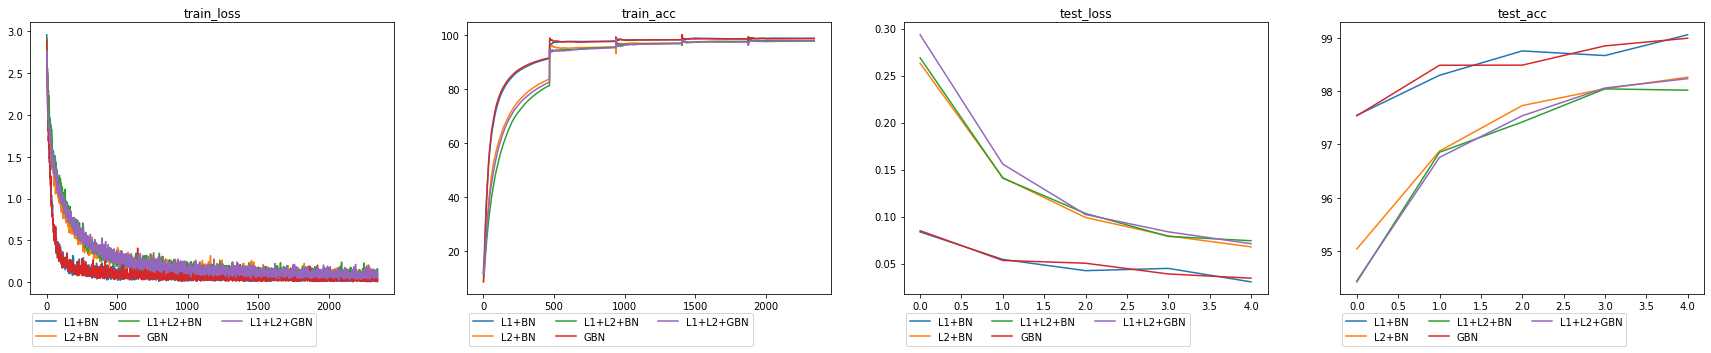

In [20]:
fig, axs = plt.subplots(1,4,figsize=(30,5))
axs_pos = {'train_loss':(0),
'train_acc':(1),
'test_loss':(2),
'test_acc':(3)}
for d in data:
  for i in data[d]:
    ax = axs[axs_pos[i]]
    ax.plot(data[d][i],label=d)
    ax.legend(bbox_to_anchor=(.8, -.05),ncol=3)#,#bbox_transform=ax.transAxes)
    ax.set_title(i)